
</br></br></br>
<font size="+10">제모옥은 데이타 분석으로 하겠습니다</font>
<font size="-1">근데 이제 모델을 곁들인</font>
</br></br></br>



### 이문제를 어떻게 접근해야 할지 고민해 보았습니다.
- 첫번째로 물류이동량에 직접적인 영향을 끼칠만한 이슈들에 대한 데이터가 아닌, 단순히 물류이동량의 통계 데이터만을 가지고 있었기에, 정확한 예측의 어려움이 있습니다.<br/>
(함축적인 데이터라고 생각했습니다. 물론, 세세한거까지 다 확인하는게 어렵습니다.)
- 두번째로 이번대회의 평가지표로 RMSE가 사용된다는것을 확인했습니다.
- 세번째로 1주에 대한 물류이동량을 시간대별로 예측한 결과물을 제출해야하는데,
학습시킬수있는데이터는 약 20주에 대한 데이터가 있습니다. 단순히 linear regression 문제로 접근한다면 쉽게 결과를 예측할수 있지만(예를 들어, 수열같은 경우), 첫번째와 같은 이유로 정확한 예측은 어렵다고 생각했습니다.


In [17]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [18]:
df_train = pd.read_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/data/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/data/test.csv")
# df_test dataframe을 168까지만 읽어들인건, 이후의 데이터는 예측해야하는 값이기 때문입니다.
df1 = df_test[:168]

In [19]:
# 위에서 읽어들인 train data와 test data를 concat 하겠습니다.
df = pd.concat([df_train, df1])
df = df.reset_index(drop=True, inplace=False)
len(df)

3447

In [20]:
# data frame에 있는 도로이름들을 따로 모아서 리스트로 만들어보았습니다.
col_list = df.columns
col_list = col_list[2:]

# EDA

### 각 도로별 물류이동량.
- 도로별로 크게 2개의 봉우리가 나타나는것을 확인하실수 있습니다.<br/>(예외인 경우도 있습니다. 물류이동량이 명절과 연휴에 영향을 받지 않는다라고 생각하였습니다.)
  - 왼쪽부터 첫번째 봉우리는 2020년 설날연휴를 의미하며, 2번째 봉우리는 2020년 5월초의 황금연휴를 나타냅니다.
<br/><br/>
- 각 도로별 물류이동량에 대한 평균치가 매우 상이하다는것을 알 수 있습니다.
<br/><br/>
- 1100, 3000번과 같은 도로들은 주중에 물류이동량이 많았으며,<br/>600, 650번과 같은 도로들은 주말에 물류이동량이 많다는것을 알수있습니다.<br/>(이 부분에서 물류이동량이라는 단어보다 교통량이라는 단어가 더 어울리것같다는 생각을 했습니다. 앞으로는 교통량이라고 하겠습니다.)
<br/><br/>
- 아무래도 2020년 데이터이다 보니, 코로나와의 연관성을 비교해보았으며, 아래와 같은 생각을 하게 되었습니다.
  - 2020-01-24 ~ 2020-01-27 &nbsp;&nbsp;&nbsp;**설연휴** <br/>
  2020-02-23 ~ 2020-02-28 &nbsp;&nbsp;&nbsp;대구경북 거리두기 3단계 <br/>
  2020-02-28 ~ 2020-05-05 &nbsp;&nbsp;&nbsp;전국 거리두기 3단계<br/>
  2020-03-22 ~ 2020-04-07 &nbsp;&nbsp;&nbsp;강화된 거리두기(다인이용시설 통제)<br/>
  2020-04-08 ~ 2020-04-19 &nbsp;&nbsp;&nbsp;첫 집합금지 명령 <br/>
  2020-04-30 ~ 2020-05-05 &nbsp;&nbsp;&nbsp;**황금연휴**<br/>
  2020-05-06 ~ 2020-08-15 &nbsp;&nbsp;&nbsp;거리두기 1단계<br/>
  <br/><br/>
  - 1510, 3000, 301, 370, 400, 352번과 같은 도로들은 2020.3월을 기점으로 코로나와 관계있어보이는 변화량을 보여주었습니다.
  - 3000번 도로는 전국 거리두기 3단계를 기점으로 교통량이 확 줄었다가, 황금연휴에 급상승한 결과를 보실수도 있습니다.


<br/><br/><br/>
### train data에 대한 그래프 밑에 지난주와 지지난주에 대한 그래프를 보시면서, 최종결론을 얘기해 드리겠습니다.<br/>(여기서 말하는 지난주와 지지난주는 저희가 최종적으로 예측해야하는 target week를 기준으로 말씀드리는것입니다.)

In [21]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})  
    
    
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

In [24]:
df1 = df_train[-168:]
df1 = df1.reset_index(drop=True, inplace=False)
df2 = df[-168:]
df2 = df2.reset_index(drop=True, inplace=False)

### 일주일만 분석해보았습니다.

- 여기서부터는 그래프만 보더라도 문제점들이 나타나기 시작합니다.
  - 첫번째로 데이터들이 0값을 가지는 경우가 종종 있습니다. (ex. 121, 101 등등)
  - 두번째로 0값은 아니지만 동일하고 연속된 값을 가지는 경우가 있습니다. (ex, 270, 251 등등)
  - 세번째로 곳곳에 튀는값들이 있지만, 제공받은 data들로만으로는 학습을 시키기가 어렵다고 생각했습니다.<br/>
  (어떤한 이유로 튀는값이 형성되었다라는 근거가 부족하다는 느낌을 받았습니다.<br/>예시를 들면,<br/>모델을 학습시켯을때, 모델의 예측결과가 튀는값으로 나왔고, 실제값도 튀는값이라고 한다면,예측이 맞아떨어진경우입니다.<br/>그런데, 교통량의 데이터만을 가지고 그러한 예측을 해서 결과를 맞추었다는게 이해가 가지 않았습니다.)



### EDA 결론:
- 경제,&nbsp;&nbsp;코로나,&nbsp;&nbsp;날씨,&nbsp;&nbsp;각 도로별 통행금지 등등 교통량과 밀접한 요소들은 많이 있지만, 저희는 교통량만을 가지고 교통량을 예측해야합니다.
- 또한, 같은 도로라고 할지라도 시간대별로 교통량이 매우 상이합니다.<br/>(튀는 값들도 포함해서요.)
- 마지막으로 밑에 이미지를 보시면, 4월27일부터 5월 24일까지의 시간대별 교통량을 trend로 본것입니다.

<br/><br/><br/>
## 저는 trend를 보고서 튀는값들에 굉장히 영향을 많이 받는다고 생각했습니다.
- 저희가 예측해야하는 1주의 데이터가 튀는값이 많을수도 있고, 적을수도 있는데,
모델이 이 부분을 예측해 줄수있을까? 어렵지 않을까? 하는 생각을 했습니다.


![image](https://cdn.discordapp.com/attachments/940518751974080532/944213205343940618/Screen_Shot_2022-02-18_at_9.46.06_PM.png)

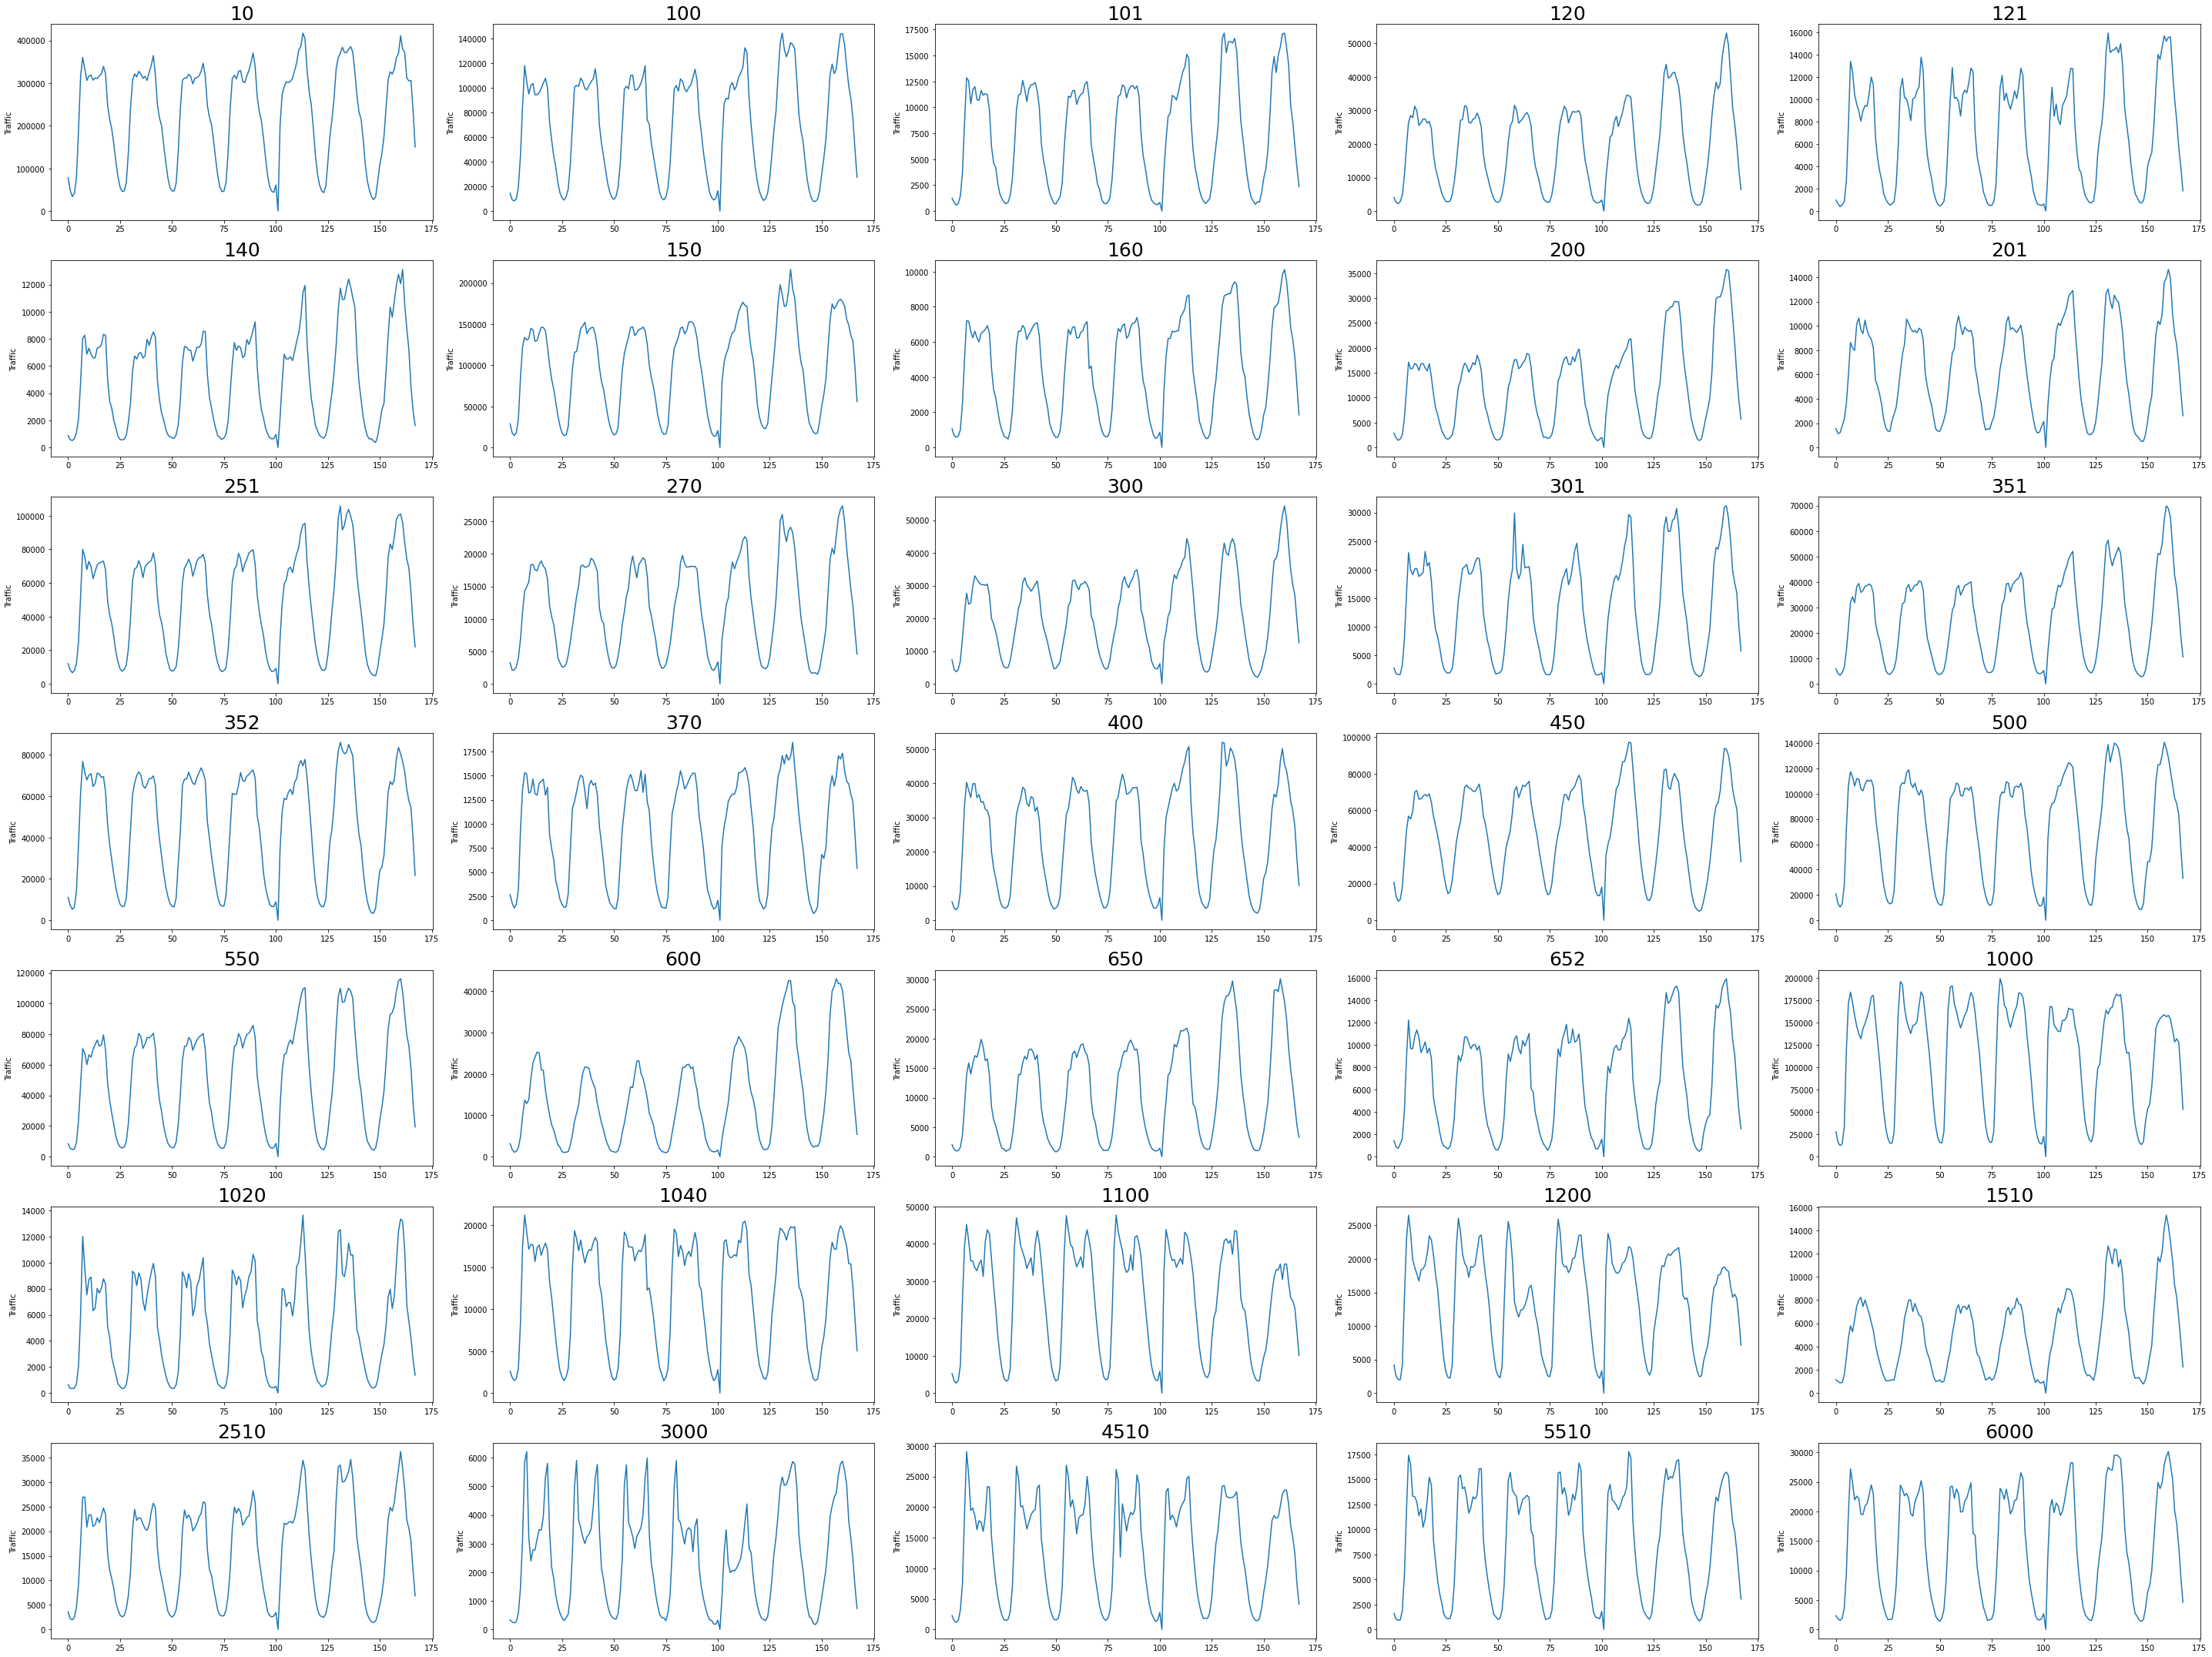

In [23]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df1[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})

plt.tight_layout()

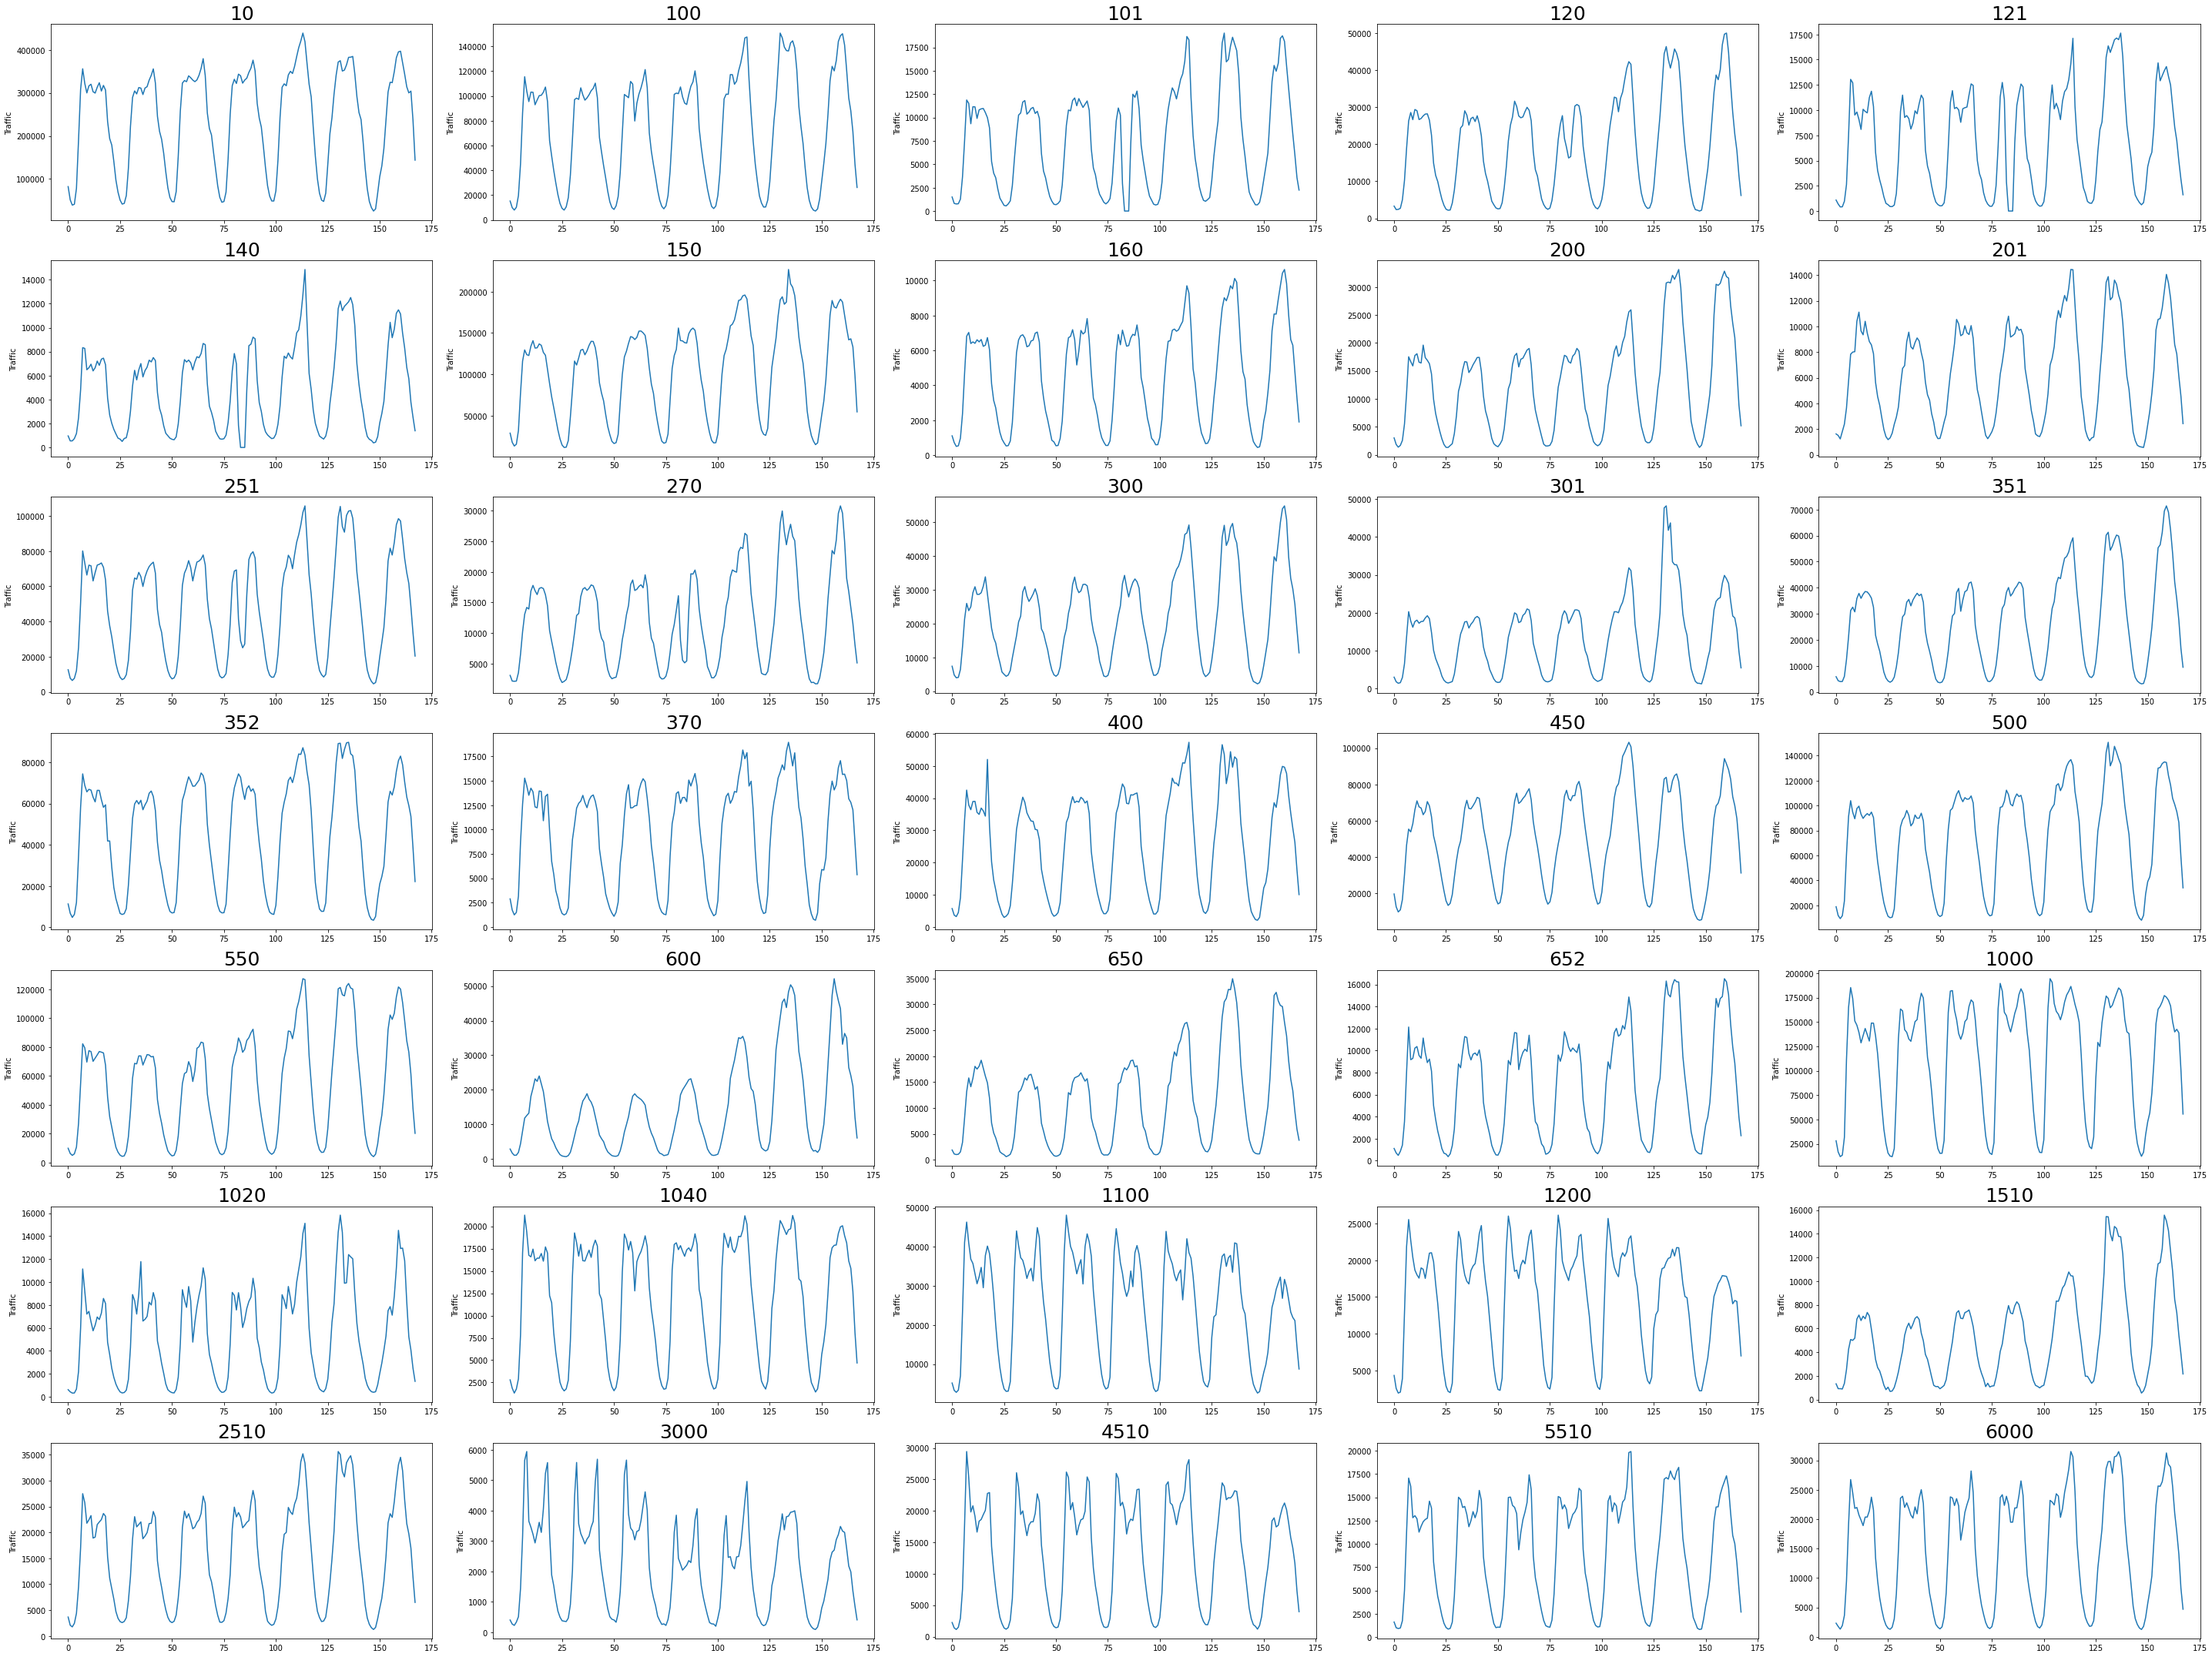

In [25]:
plt.figure(figsize=(40, 30))
plt.subplots_adjust(top=1.25, bottom=1.2)

for i, col in enumerate(col_list, 1):
    plt.subplot(7, 5, i)
    df2[col].plot()
    plt.ylabel('Traffic')
    plt.title(col, fontdict = {'fontsize' : 25})

plt.tight_layout()

In [27]:
# 데이터에대한 min-max 값 확인( RMSE값을 어떻게 하면 줄일수 있을가에 대한 고민.)
# min값으로 0값이 보인다..(이런 부분을 수정해주어야 할것으로 보인다.)
df.describe()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,3.447000e+03,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000,3447.000000
mean,2.020031e+07,11.472875,232021.168262,66991.016826,7160.330432,17442.762402,6646.486510,4697.286336,99557.964317,4405.759501,11458.208007,6271.665216,47602.675950,12449.892950,19868.424137,12310.680592,26072.304032,43411.109080,8115.389614,22721.014795,48052.715985,76412.085001,49636.396867,14016.921961,11108.966057,6527.568900,110669.988686,5168.441543,10974.525384,27063.472295,13961.833188,4895.391645,14698.942269,2449.119814,12171.445605,8004.364085,14016.497534
std,1.384586e+02,6.925212,121832.588162,41786.472220,5568.256295,13326.993013,4795.946084,3538.158435,58404.831050,2858.852244,8746.387547,4230.889371,30133.632004,8676.942867,13891.596710,9141.443023,19411.678234,26577.748942,4912.280383,14549.194374,25965.710777,43673.145535,37052.637356,12910.502070,9473.132300,4847.251117,59194.026956,3886.411431,6194.492335,15518.485871,7124.215199,4074.871094,9595.589258,1861.079709,8019.041923,5241.226791,9303.941733
min,2.020010e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.020020e+07,5.000000,112123.000000,23554.500000,1898.500000,5222.000000,1700.000000,1312.500000,43252.000000,1534.000000,3217.500000,2349.000000,16733.000000,4587.000000,7786.500000,3561.000000,8478.500000,16005.000000,3111.000000,7823.500000,25025.500000,32424.500000,14018.500000,2949.500000,2479.500000,1785.500000,51123.500000,1311.000000,4535.000000,11501.000000,7274.000000,1516.000000,4989.000000,713.500000,3620.000000,2558.000000,3976.500000
50%,2.020031e+07,11.000000,267845.000000,74265.000000,6934.000000,16681.000000,7008.000000,4712.000000,112017.000000,4772.000000,10840.000000,5939.000000,52165.000000,11643.000000,18291.000000,12348.000000,25138.000000,49159.000000,8784.000000,24360.000000,49212.000000,87784.000000,50236.000000,10525.000000,9770.000000,6690.000000,132681.000000,5167.000000,12921.000000,30836.000000,16013.000000,4261.000000,15933.000000,2198.000000,13631.000000,8625.000000,15221.000000
75%,2.020042e+07,17.000000,327604.500000,100138.500000,10918.000000,26118.000000,10332.000000,6964.000000,141126.000000,6671.000000,16599.500000,9361.500000,70081.000000,18243.500000,28632.000000,18232.000000,37345.000000,64981.500000,12259.000000,34690.500000,67765.000000,109330.500000,74323.500000,20311.500000,16639.500000,9982.000000,160155.500000,8153.000000,16295.000000,38846.000000,19474.500000,6801.000000,21828.000000,3727.000000,18798.000000,12561.000000,22114.000000
max,2.020052e+07,23.000000,580098.000000,200808.000000,45869.000000,114833.000000,24596.000000,24639.000000,292004.000000,14163.000000,48349.000000,33416.000000,165038.000000,56939.000000,99035.000000,53279.000000,131904.000000,118109.000000,19309.000000,74691.000000,153141.000000,215521.000000,239389.000000,67751.000000,58262.000000,37465.000000,224895.000000,21409.000000,25891.000000,76629.000000,35192.000000,28531.000000,45531.000000,10581.000000,38061.000000,21229.000000,36915.000000


In [9]:
# NaN값은 없습니다.
# df.isnull().sum()

In [26]:
# 코로나 이후의 데이터를 표현해주고있습니다.
df[1453:].head()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
1453,20200302,0,59436,10736,910,2347,750,514,20558,628,1684,1134,9256,2177,4050,1891,4297,7699,1428,3764,14953,13625,4864,2021,1186,828,20938,526,1825,4620,3210,775,2516,192,1337,1162,1952
1454,20200302,1,39179,7737,562,1649,411,471,14273,477,1249,988,6173,1687,3145,1573,3330,5287,1041,2809,11194,10034,3572,1034,969,548,13426,357,1204,2929,2059,731,1758,146,951,809,1221
1455,20200302,2,32681,6733,462,1566,264,449,11498,420,1002,928,5856,1648,2763,1238,2949,4299,777,2514,9173,8862,3195,787,743,352,10998,259,1057,2515,1686,571,1541,157,723,617,1136
1456,20200302,3,38254,8835,587,1808,370,574,14131,456,961,1528,6680,2010,3241,1548,3195,5448,948,3899,9944,10636,3854,1057,750,705,12385,280,1300,3124,1769,849,2148,184,1116,839,1514
1457,20200302,4,66913,17306,1133,3538,589,884,28211,923,1446,1999,10294,3025,5058,2469,5546,9896,1686,7387,15148,20497,6407,1752,1146,1498,27276,521,2687,7410,3439,1274,3610,361,1919,1689,2882


In [11]:
# 데이터 결측치를 표현해주고 있습니다.
df[882:883]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
882,20200206,18,0,86,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,5,49,0,0,4,0,0,0,35,0,0


In [12]:
# 데이터 결측치를 표현해주고 있습니다.
df[3212:3213]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3212,20200515,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [28]:
# 데이터 결측치를 표현해주고 있습니다.
df[3360:3367]

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3360,20200521,9,321981,101842,10269,27726,11048,6978,155996,6323,15972,8336,69338,16100,25201,19222,33538,71229,13886,41482,63216,103460,77514,14087,14973,9728,159884,7560,17388,35914,19875,5927,23000,2433,20816,13748,22349
3361,20200521,10,343667,107261,2942,21563,2881,1831,140808,7163,17779,10082,41336,8805,31776,20506,38214,74439,12688,44438,73441,112303,86261,18560,16709,11716,156349,9071,17838,33240,18792,7137,23833,2246,21369,14187,23894
3362,20200521,11,339887,99234,0,19127,0,0,140396,6696,17574,10795,28991,5549,34215,19625,40070,72799,13283,43235,76758,108672,82784,19970,17758,11140,146808,7853,17197,29479,18025,7938,22988,2045,20082,13671,22567
3363,20200521,12,322724,94243,0,16294,0,0,138321,6241,16659,9169,25061,5119,30711,17176,36812,66742,13299,38411,72243,101047,76343,20934,17346,10337,139759,6034,16643,27321,17244,7317,20898,2125,16320,11651,19487
3364,20200521,13,329873,93115,0,16674,0,0,137759,6276,16384,9279,27200,5424,27842,18269,37873,62039,12864,38264,70970,99667,78441,21897,18030,9923,148588,6709,17356,29011,18653,7241,21368,2206,18046,12433,19496
3365,20200521,14,334335,101138,7225,24275,6751,4802,149134,6716,17645,9427,55234,13798,30310,19473,39562,67227,15080,41066,73779,105869,84526,22942,19125,10239,158742,7698,17587,33825,19185,7900,21934,2359,18697,13151,21906
3366,20200521,15,347699,107829,12495,30297,10466,8501,153721,6923,18046,9987,75239,19689,32150,20722,40636,68661,14469,40978,73787,109283,86438,23215,19244,10018,165470,8308,17205,29813,19964,8259,22285,2296,18462,13428,21927


In [29]:
## 데이터의 결측치라고 판단되는 값들을 처리하고 있습니다.

drop_index = list()

# 코로나 데이터 삭제
df = df[1453:]
df = df.reset_index(drop=True, inplace=False)

for index, row in df.iterrows():
  # 0값을 가지는 row들은 삭제하겠습니다.
  for col in col_list:
    if row[col] == 0:
      drop_index.append(index)
      break

# vacations = [20200124, 20200125, 20200126, 20200127, 20200430, 20200501, 20200502, 20200503, 20200504, 20200505]
vacations = [20200123, 20200124, 20200125, 20200126, 20200127, 20200128, 20200429, 20200430, 20200501, 20200502, 20200503, 20200504, 20200505, 20200506]
for index, row in df.iterrows():
  # 설날연휴와 황금연휴는 삭제하겠습니다.
  if row["날짜"] in vacations:
    drop_index.append(index)
  

# print(drop_index)
df = df.drop(drop_index)
df = df.reset_index(drop=True, inplace=False)
len(df)

1798

In [30]:
# 중복된 인덱스가 없다는것을 확인했습니다.
# from collections import Counter
# c = Counter(drop_index)
# c

In [31]:
df.describe()

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,1.798000e+03,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.00000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.000000,1798.00000,1798.000000,1798.000000,1798.000000,1798.000000
mean,2.020040e+07,11.490545,224486.565628,65763.626808,6899.966073,16440.104004,6742.968298,4663.933259,98898.330923,4202.643493,10956.880979,5968.174082,46409.190768,11778.948276,18710.659622,12091.626251,23806.59010,43501.139043,8778.528365,22908.403782,45618.347052,74150.106229,45773.957731,13571.838710,10313.381535,6195.761958,113357.177976,4995.240823,11111.213571,26389.729700,14455.950501,4716.375973,14319.03337,2190.780868,11994.189655,8245.850945,13890.589544
std,7.777003e+01,6.935883,115607.180963,40200.863520,4886.841042,11343.305765,4725.480693,3276.995859,56436.608376,2652.627176,8062.507730,3640.108808,28531.325183,7432.153647,11626.039988,8494.496672,15872.73704,26533.208752,5166.563131,14376.561841,23330.633787,41863.114258,31374.177209,12101.352553,8086.932497,4280.689593,60276.696188,3639.813092,6262.657655,15313.534541,7245.504916,3457.057350,9085.39292,1611.584775,7792.023717,5300.390322,9101.865943
min,2.020030e+07,0.000000,18729.000000,3927.000000,313.000000,937.000000,263.000000,223.000000,7095.000000,252.000000,719.000000,300.000000,3129.000000,934.000000,1176.000000,491.000000,1484.00000,2415.000000,451.000000,1194.000000,3108.000000,4805.000000,2026.000000,574.000000,508.000000,289.000000,6331.000000,149.000000,746.000000,1220.000000,1040.000000,326.000000,701.00000,61.000000,581.000000,358.000000,685.000000
25%,2.020032e+07,5.000000,110455.750000,22718.500000,1873.750000,5049.250000,1776.000000,1323.000000,43011.500000,1473.250000,3254.500000,2339.750000,16373.000000,4427.250000,7820.750000,3647.500000,7964.00000,16134.250000,3371.250000,7853.500000,24232.000000,30432.500000,13467.250000,2943.500000,2445.250000,1703.500000,52833.000000,1305.500000,4555.250000,10576.500000,7896.000000,1525.000000,5021.50000,629.250000,3587.500000,2648.000000,3875.750000
50%,2.020041e+07,11.000000,265069.500000,74862.000000,7014.000000,16790.500000,7255.000000,4960.000000,114629.500000,4612.500000,10748.500000,5934.000000,52592.000000,11345.000000,18084.500000,12691.500000,24103.00000,49899.500000,9908.500000,25147.000000,47217.500000,87047.000000,48932.000000,10622.000000,9554.500000,6535.500000,137559.500000,5154.500000,13213.000000,30428.000000,16977.500000,4275.500000,15990.50000,2130.000000,13810.500000,8907.000000,15346.000000
75%,2.020043e+07,17.750000,318807.000000,98883.500000,10866.750000,25189.750000,10563.000000,7007.750000,142047.000000,6418.000000,15948.750000,9131.000000,68946.000000,17900.750000,27611.250000,18241.500000,35168.50000,64771.000000,13199.250000,35151.250000,64869.250000,106049.000000,70077.500000,19945.250000,15922.250000,9653.750000,162784.750000,8002.250000,16524.500000,37749.000000,19946.000000,6811.750000,21292.75000,3354.000000,18257.250000,12864.000000,21921.750000
max,2.020052e+07,23.000000,472649.000000,151778.000000,19999.000000,53098.000000,17634.000000,16051.000000,226740.000000,11032.000000,35738.000000,15230.000000,111768.000000,33417.000000,54732.000000,48226.000000,73079.00000,109255.000000,18952.000000,58002.000000,107077.000000,154175.000000,139101.000000,52156.000000,34969.000000,16835.000000,224895.000000,17293.000000,21281.000000,73117.000000,35192.000000,17046.000000,37632.00000,7824.000000,30182.000000,21229.000000,31504.000000


### 데이터셋 재정의
- EDA를 통하여 요일별 시간별로 따로따로 예측을 해주면 되겠다라고 생각을합니다.
- 최종결과물은 168 * 35의 형태를 가지고 있습니다.<br/>
여기서 168이란 24 * 7 이며,<br/> 24는 시간대를 의미하고, 7은 월화수목금토일(요일)을 의미합니다.<br/>
35는 도로의 갯수입니다.
- 1월1일부터 5월 24일까지 각 도로에 대한 월요일 0시 데이터들을 모으고, 1시데이터를 모으고,<br/>
그렇게 계속해서 일요일 23시 데이터까지 모읍니다.<br/>(저는 아래와 같은 형태를 고려했습니다.)
```python
Monday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Tuesday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Wednesday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Thursday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Friday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Saturday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
Sunday = { '10': {0: [...], 1: [...], ..., 23: [...]}, '100': {0: [...], 1: [...], ..., 23: [...]}, ..., '6000': {0: [...], 1: [...], ..., 23: [...]}}
```
이렇게 되면 linear regression만으로도 문제를 해결할수있습니다.<br/>
하지만, 제가 EDA에서 말씀드린대로 튀는값에 대해서는 대처가 불가능하다고 생각했습니다.<br/>
그리하여 RMSE를 이용하자고 생각했습니다.<br/><br/><br/><br/>


In [32]:

days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

Monday = dict()
Tuesday = dict()
Wednesday = dict()
Thursday = dict()
Friday = dict()
Saturday = dict()
Sunday = dict()

for col in col_list:
  Monday[col] = dict()
  Tuesday[col] = dict()
  Wednesday[col] = dict()
  Thursday[col] = dict()
  Friday[col] = dict()
  Saturday[col] = dict()
  Sunday[col] = dict()
  for i in range(24):
    Monday[col][i] = list()
    Tuesday[col][i] = list()
    Wednesday[col][i] = list()
    Thursday[col][i] = list()
    Friday[col][i] = list()
    Saturday[col][i] = list()
    Sunday[col][i] = list()



for i in range(len(df)):
  year = str(df["날짜"][i])[:4]
  month = str(df["날짜"][i])[4:6]
  day = str(df["날짜"][i])[6:]
  b = days[datetime.date(int(year), int(month),int(day)).weekday()]
  # print(b, df.시간[i], df["100"][i], df.loc[i][2])

  for idx, col in enumerate(col_list):
    # print(df.loc[i][idx+2])
    if b == "Monday":
      Monday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Tuesday":
      Tuesday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Wednesday":
      Wednesday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Thursday":
      Thursday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Friday":
      Friday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Saturday":
      Saturday[col][df.시간[i]].append(df.loc[i][idx+2])
    elif b == "Sunday":
      Sunday[col][df.시간[i]].append(df.loc[i][idx+2])
        


### 아래의 그래프를 보시면 시간에 따른 관계가 있는것처럼 보이시나요?

---




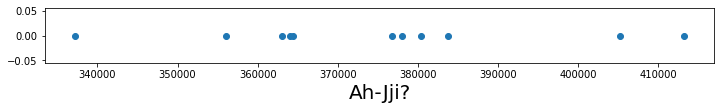

In [218]:
# x = Wednesday["10"][0]
# x = Monday["10"][15]
x = Friday["10"][15]

y = [0 for val in x]
fig, ax = plt.subplots()
fig.set_size_inches(12,1)
ax.set_xlabel("Ah-Jji?", fontsize=20)
plt.scatter(x,y)


149.0

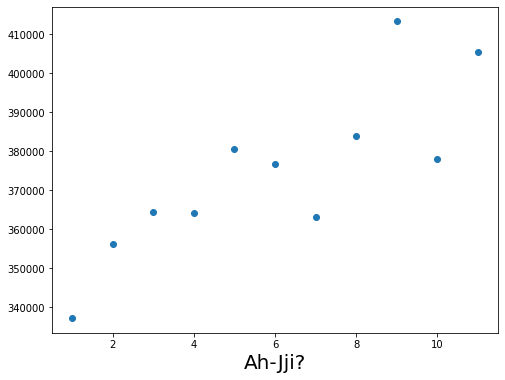

In [219]:
y = [val+1 for val in range(len(x))]
fig, ax = plt.subplots()
fig.set_size_inches(8,6)
ax.set_xlabel("Ah-Jji?", fontsize=20)
plt.scatter(y,x)
105 + 88 / 2


### 정확하게 튀는값을 맞추려고 하지말고, 안전하게 무난한값을 선택하면 되지 않을까?
#### 증가하는 추세를 유지하면서, 그럴싸한 값을 제출하면 되지 않을까?
위와 같은 생각을 하게 되고, 시험삼아 지난주와 지지난주의 데이터의 평균값을 대입해서 
제출해본 결과, 훌륭한 점수를 얻어낼수 있었습니다.<br/>


---


public 3620점, private 3623점을 기록하였습니다.<br/>
지난2주의 데이터의 평균을 구하는데,지난주 데이터에 5%의 가중치를 더해주고, 지지난주 데이터에 2.5%의 가중치를 뺴줌으로써 나온 결과입니다.
![image](https://github.com/NOTITLEUNTITLE/MNC_traffic/blob/main/image1.PNG?raw=true)

<br/><br/><br/>



---


최종적으로는 public점수가 3500점이 나온걸 택했지만, private 점수가 3790이 나왔습니다.<br/>
지난 3주의 데이터를 평균을 구하는데, 지난주 데이터에 5%의 가중치를 더해준 결과를 제출하였을때의 점수였습니다.<br/>
위로 미루어 보아, 위에서 보여드린 그래프에서도 알수있었듯이, **아마도 대다수의 도로들이 증가하는 추세**를 보이고 있다고 생각됩니다.








![image](https://github.com/NOTITLEUNTITLE/MNC_traffic/blob/main/image3.PNG?raw=true)



### 여기까지가 이번대회에서 고민한 내용들입니다.
- 첫번째로 아쉬운점은, linear regression 모델을 구현해서, 모델의 예측값을 확인해보려했으나, 대회종료 4분전임을 알았으며, 시도하지 못했습니다..
- 두번재로 아쉬운점은, 각 도로별로 11-12개의 데이터들의 증가세와 감소세를 코딩으로 확인해 보려했으나, 대회종료 3분전임을 알았으며, 시도하지 못했습니다..<br/>
  - 11-12개 정도되는 데이터를 시간순서대로 증가했는지, 감소했는지 확인한후,<br/>과반이상이 증가했다면 가중치를 더해주고,<br/>과반이상이 감소했다면 빼주는 방법을 생각했습니다.<br/> 도로별로 교통량이 상이하기에 volume도 고려해야합니다.(단순히 증가했다, 감소했다가 아니라 증가량,감소량이 중요합니다.)<br/>
아니면, 끝에 데이터 2-3개만 해보는것도 정확할 것 같습니다.



### linear regression
- Linear regression 참고 사이트
- <a href="https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#simple-linear-regression-basics" taget="_blank">https://www.deeplearningwizard.com/deep_learning/practical_pytorch/pytorch_linear_regression/#simple-linear-regression-basics</a>

### 파일 제출

In [ ]:
Mon_result = list()
Tues_result = list()
Wednes_result = list()
Thurs_result = list()
Fri_result = list()
Satur_result = list()
Sun_result = list()



for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Monday[col][i][-3:]) + (Monday[col][i][-1] * 0.05) ) / len(Monday[col][i][-3:]), 1)
    temp.append(value)
  Mon_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Tuesday[col][i][-3:]) + (Tuesday[col][i][-1] * 0.05) ) / len(Tuesday[col][i][-3:]), 1)
    temp.append(value)
  Tues_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Wednesday[col][i][-3:]) + (Wednesday[col][i][-1] * 0.05) ) / len(Wednesday[col][i][-3:]), 1)
    temp.append(value)
  Wednes_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Thursday[col][i][-3:]) + (Thursday[col][i][-1] * 0.05) ) / len(Thursday[col][i][-3:]), 1)
    temp.append(value)
  Thurs_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Friday[col][i][-3:]) + (Friday[col][i][-1] * 0.05) ) / len(Friday[col][i][-3:]), 1)
    temp.append(value)
  Fri_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Saturday[col][i][-3:]) + (Saturday[col][i][-1] * 0.05) ) / len(Saturday[col][i][-3:]), 1)
    temp.append(value)
  Satur_result.append(temp)

for col in col_list:
  temp = list()
  for i in range(24):
    value = round( (sum(Sunday[col][i][-3:]) + (Sunday[col][i][-1] * 0.05) ) / len(Sunday[col][i][-3:]), 1)
    temp.append(value)
  Sun_result.append(temp)

In [ ]:
submit = pd.read_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/data/sample_submission.csv")

In [ ]:
pivot = 24

for i, col in enumerate(col_list):
  submit[col][:pivot] = Mon_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot:pivot*2] = Tues_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*2:pivot*3] = Wednes_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*3:pivot*4] = Thurs_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*4:pivot*5] = Fri_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*5:pivot*6] = Satur_result[i]

for i, col in enumerate(col_list):
  submit[col][pivot*6:] = Sun_result[i]



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/lo

In [ ]:
submit.describe()

,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,238149.952976,71554.073810,7496.908929,19399.137500,7046.980357,5123.365476,104745.825595,4641.280357,12437.235119,6476.518452,49990.982143,12313.426786,21694.207738,13921.433929,26684.043452,47704.597024,9747.650000,25574.258929,50811.271429,76092.020833,53498.107143,14197.763690,11243.919048,6840.047024,117064.892262,5578.243452,12090.369643,28620.226190,14738.189881,5281.454167,16131.097024,2501.199405,13493.954167,8994.357738,14997.389881
std,118088.570083,42688.296885,5168.835008,12866.440642,4788.801158,3537.096931,57301.159409,2868.699257,8626.670575,3871.799815,29844.324760,7385.104101,12961.254164,9466.061948,17350.663724,27151.395115,5357.914857,15587.946649,25265.975597,40860.572118,35459.175087,11571.533613,8435.931368,4588.909154,58698.766216,3977.024147,6586.618829,15794.531578,7091.712837,3639.313443,9966.315185,1722.748986,8321.525731,5597.280600,9554.985009
min,25350.700000,7132.000000,627.700000,1854.000000,426.000000,375.000000,13416.000000,440.700000,1344.700000,520.700000,4783.300000,1497.000000,2053.300000,1211.000000,2758.300000,3245.700000,697.700000,1988.700000,4894.300000,8132.300000,3927.300000,904.700000,785.700000,534.300000,12305.700000,310.300000,1372.000000,2824.000000,1983.000000,671.700000,1290.300000,123.000000,1160.300000,785.700000,1303.000000
25%,126874.700000,26513.175000,2283.800000,6438.075000,2107.200000,1517.100000,52310.025000,1872.700000,4327.100000,2528.025000,19441.325000,4727.975000,10027.975000,4631.475000,9501.250000,21906.000000,4280.050000,8991.275000,30804.900000,35852.575000,18436.675000,3399.425000,3035.175000,2194.325000,58459.775000,1541.600000,5294.475000,12513.925000,8763.450000,1899.425000,5964.700000,782.475000,4518.100000,3193.025000,4703.200000
50%,301079.650000,84353.850000,7867.650000,20438.350000,7559.350000,5386.500000,120402.650000,5181.350000,12994.650000,6786.800000,55121.650000,12253.350000,22032.150000,15209.500000,28171.800000,57315.150000,11888.200000,29345.650000,52929.350000,93757.000000,62522.350000,12233.800000,10258.300000,7555.650000,143926.850000,5633.000000,14965.500000,33369.800000,17339.200000,4987.200000,17745.850000,2534.800000,16067.850000,10014.000000,16501.800000
75%,329026.250000,105537.100000,11418.400000,28093.775000,10769.450000,7520.025000,145868.325000,6919.950000,17554.175000,9659.500000,72738.225000,18178.025000,30664.700000,20381.175000,38420.000000,71114.175000,14166.300000,38288.250000,71260.800000,106863.225000,78756.175000,20858.300000,17518.925000,10309.025000,163073.950000,8772.225000,17521.075000,41741.575000,20188.350000,7388.775000,23334.325000,3624.675000,20047.100000,13830.975000,23346.400000
max,443076.000000,147103.000000,17898.000000,51769.000000,15503.000000,14284.000000,212489.300000,10597.300000,34127.700000,14358.300000,104612.300000,29374.700000,54498.700000,36435.300000,71458.000000,85929.700000,17360.700000,55376.700000,102490.300000,140492.000000,125244.700000,43308.700000,29377.700000,16347.000000,192634.700000,14742.000000,21247.700000,57438.700000,26264.000000,15779.300000,36119.300000,6359.300000,29193.700000,19551.300000,30560.300000


In [ ]:
submit.to_csv("/content/drive/MyDrive/PyTorch_YearDream/2022-02-17/submit/asdfasdf.csv")